# Pretrained Model
### The reason that it is introduced
* [ILSCVRC](http://image-net.org/)에서 1000개의 클래스를 classification하는 문제를 solving한 모델이 있다.
* 이모델은 1000개를 분류할 수 있는 능력이 있지만 수백만장의 이미지 데이터를 다시 트레이닝하는 것은 매우 무리다.
* 그래서 연구소에서는 이모델을 open source로 제공하는 방향으로 연구를 하고 이를 우리는 사용해 좋은 **visual features **를 이용할 수 있게 되었다.
* 사용법은 매우 간단하다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
transform_train = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load and Define pretrained model and fine-tuning

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary

In [10]:
class ResNet18(nn.Module):
    def __init__ (self, use_pretrained):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained = use_pretrained)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)
        self.resnet.layer4.1 = 
        #implement this
        
    def forward(self, x):
        x = self.resnet(x)
        return x
# model = ResNet18(False)
# model = ResNet18(True)

## Load Model

In [22]:
import torch.optim as optim

net_pretrained = ResNet18(use_pretrained = True)
resnet = models.resnet18()
print(resnet.state_dict())
summary(net_pretrained, batch_size=-1, input_size=(3, 32, 32), device='cpu')
net_pretrained = net_pretrained.to(device)

OrderedDict([('conv1.weight', tensor([[[[-4.3103e-02,  1.4430e-03, -6.7227e-04,  ...,  2.4439e-02,
            9.6144e-03, -4.1208e-02],
          [-2.2977e-02,  1.5800e-02, -4.6411e-02,  ...,  5.1982e-02,
            3.7038e-02,  1.2279e-02],
          [-3.1471e-02, -7.0602e-02, -1.9993e-03,  ..., -1.2423e-02,
           -4.2352e-02,  1.8182e-02],
          ...,
          [-2.1083e-02,  2.0467e-02,  7.6337e-03,  ...,  2.1032e-02,
            1.8262e-02, -2.3509e-02],
          [ 3.3983e-03,  3.7749e-02, -8.6227e-03,  ..., -2.2069e-02,
           -1.0803e-02, -1.8231e-05],
          [ 1.0688e-02,  2.5142e-02, -4.4891e-02,  ..., -5.9538e-03,
            1.6888e-02,  3.1029e-02]],

         [[ 1.4694e-03,  1.3592e-03,  2.7052e-02,  ...,  3.3175e-02,
           -3.5559e-02,  6.0280e-02],
          [-6.0150e-04,  1.8096e-02,  3.1666e-02,  ..., -1.6542e-02,
            2.8859e-02,  1.9268e-02],
          [-7.5985e-03, -6.1283e-02, -1.6149e-02,  ...,  1.6900e-02,
           -2.3723e-02, -4.6

## Training pretrained model

In [7]:
training_epochs = 5
learning_rate = 0.01

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net_pretrained.parameters(), lr=learning_rate, momentum = 0.9)

net_pretrained.train()

for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net_pretrained(inputs) 
        loss =  criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # print statistics
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0
print('Finished Training')

[1,   500] loss: 0.268
[2,   500] loss: 0.219
[3,   500] loss: 0.179
[4,   500] loss: 0.139
[5,   500] loss: 0.140
Finished Training


## Test pretrained model

In [8]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

net_pretrained.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net_pretrained(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('Mean Accuracy : ', 100*np.sum(class_correct)/np.sum(class_total))

Accuracy of plane : 80.600000 %
Accuracy of   car : 85.800000 %
Accuracy of  bird : 72.800000 %
Accuracy of   cat : 70.000000 %
Accuracy of  deer : 77.200000 %
Accuracy of   dog : 69.700000 %
Accuracy of  frog : 86.800000 %
Accuracy of horse : 87.300000 %
Accuracy of  ship : 90.900000 %
Accuracy of truck : 91.600000 %
Mean Accuracy :  81.27


## Training unpretrained model

In [11]:
net_unpretrained = ResNet18(use_pretrained = False).to(device)
optimizer_unpretrained = optim.SGD(net_unpretrained.parameters(), lr=learning_rate, momentum = 0.9)
net_unpretrained.train()

for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_unpretrained.zero_grad()
        
        # forward + backward + optimize
        outputs = net_unpretrained(inputs) 
        loss =  criterion(outputs, labels)
        loss.backward()
        optimizer_unpretrained.step()
        
        running_loss += loss.item()

        # print statistics
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0
print('Finished Training')


[1,   500] loss: 1.683
[2,   500] loss: 1.166
[3,   500] loss: 0.924
[4,   500] loss: 0.749
[5,   500] loss: 0.634
Finished Training


## Test unpretrained model

In [17]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

net_unpretrained.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net_unpretrained(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('Mean Accuracy : ', 100*np.sum(class_correct)/np.sum(class_total))

Accuracy of plane : 83.900000 %
Accuracy of   car : 77.100000 %
Accuracy of  bird : 59.600000 %
Accuracy of   cat : 40.400000 %
Accuracy of  deer : 67.000000 %
Accuracy of   dog : 60.700000 %
Accuracy of  frog : 86.400000 %
Accuracy of horse : 72.300000 %
Accuracy of  ship : 82.100000 %
Accuracy of truck : 78.100000 %
Mean Accuracy :  70.76


## Visualization

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
        
# Get a batch of test data
dataiter = iter(testloader)

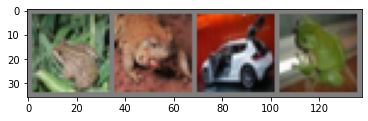

gt label:  frog  frog   car  frog
pretrained model prediction:  frog  frog   dog  frog
unpretrained model prediction:  frog  frog   car  frog


In [16]:
inputs, labels = dataiter.next()
outputs_pretrained = net_pretrained(inputs.cuda())
_, predicted_pretrain = torch.max(outputs_pretrained, 1)

outputs_unpretrained = net_unpretrained(inputs.cuda())
_, predicted_unpretrain = torch.max(outputs_unpretrained, 1)

imshow(torchvision.utils.make_grid(inputs))

print('gt label:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('pretrained model prediction:', ' '.join('%5s' % classes[predicted_pretrain[j]] for j in range(4)))
print('unpretrained model prediction:', ' '.join('%5s' % classes[predicted_unpretrain[j]] for j in range(4)))